# tb.lx Data Science Challenge - Part II
----
----
## Introduction

Dear applicant,

Congratulations on passing the first screening! We’re excited to get to know you better and get a better feeling of your competences. In this round, we will test you on your problem-solving skills and data science experience by giving you a case to solve.

After handing us over your solution, we will review it and let you know our feedback. In the case you have passed, you will be called to an on-site interview. During the interview, you’ll get the opportunity to explain your solution and the steps that you took to get there. We've prepared this notebook for you, to help you walk us through your ideas and decisions.

If you're not able to fully solve the case, please elaborate as precisely as you can:

- Which next steps you'd be taking;
- Which problems you'd be foreseeing there and how you'd solve those.

In case you have any questions, feel free to contact ana.cunha@daimler.com or sara.gorjao@daimler.com for any more info. 

Best of luck!

## Context:

Predictive Maintenance is one of the hottest topics in the heavy-industry field. The ability to detect failures before they happen is of utmost importance, as it enables the full utilization of materials saving in unnecessary early replacements, and enables optimizations in maintenance planning reducing the downtime.


## Data:

One of the challenges in the auto-tech industry is to detect failures before they happen. For this, we included a dataset including:
* `telemetry.csv`: Consists of a dataset with sensor values along time
* `faults.csv`: Consists of a dataset with faults for each machine along time.
* `errors.csv`: Consists of a dataset with errors for each machine along time.
* `machines.csv`: Consists of a dataset with features for each machine. 


## Task:

In the second part of the challenge, we would like to know that a failure is going to happen before it actually happens. The decision of the prediction horizon is totally up to you, **but the goal is to predict failures before they happen**.


## Questions:

Follows a set of theoretical questions:

1. How can you create a machine learning model that leverages all the data that we provided whilst adapting to the specificities of each turbine (e.g., operating in different weather conditions)?
2. Modeling the normal behaviour of such machines can prove itself to be a good feature. After training a model that captures the normal turbine dynamics, we need to decide when the displayed behaviour may be considered an anomaly or not. How can one design a framework that creates alerts for abnormality without overloading the end-user with too many false positives?
3. How would you measure aleatoric uncertainty of the predictions of your model?

## Requirements:

- Solution implemented in Python3.6+;
- Provide requirements.txt to test the solution in the same environment;
- Write well structured, documented, maintainable code;
- Write sanity checks to test the different steps of the pipeline;

In [ ]:
# Isto aqui vai ser muito como as coisas que ja tenho visto de TTF. Load datasets ver o RUL ver quantos time-steps faltam
# até o RUL e por ai fora
#https://www.kaggle.com/nafisur/predictive-maintenance-using-lstm-on-sensor-data
#https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot
#https://www.kaggle.com/hanwsf8/lstm-lgb-catb-for-predictive-maintenance-upper
#https://www.kaggle.com/juhumbertaf/tutorial
#https://iopscience.iop.org/article/10.1088/1742-6596/1037/6/062003/pdf
#https://www.kaggle.com/c/equipfails/overview
#https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set
#https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/predictive-maintenance-playbook#data-science-for-predictive-maintenance
#https://github.com/Azure-Samples/MachineLearningSamples-DeepLearningforPredictiveMaintenance
#https://gallery.azure.ai/Notebook/Predictive-Maintenance-Implementation-Guide-R-Notebook-2
#https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3

# Para a primeira pergunta: Dizer algo como garantir que o modelo não esta a fazer overfitting de maneira a conseguir
# adaptar-se a novas turbinas (também posso dizer "garantir que os dados são representativos do que queremos")
# aqui tambem pode ser fazer o split por machineID em vez de ser pela data

# Para a segunda pergunta: Fazer one class classification

# Para a terceira pergunta: algo como bayesian estimation

In [1]:
import bisect
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Input, Dropout, GRU, Masking
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Loading the datasets
telemetry = pd.read_csv("../data/sensor/telemetry.csv", index_col=0)
failures = pd.read_csv("../data/sensor/failures.csv")
errors = pd.read_csv("../data/sensor/errors.csv")
machines = pd.read_csv("../data/sensor/machines.csv")

Converting datetime strings to datetime objects

In [2]:
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"])
failures["datetime"] = pd.to_datetime(failures["datetime"])
errors["datetime"] = pd.to_datetime(errors["datetime"])

## Joining the additional information

Since we have other relevant information scattered on different dataframes, it is useful to  join these dataframes into one containing all the needed information

In [3]:
# Joining the newly added failures column to the telemetry dataframe
failures["failures"] = 1
telemetry = telemetry.merge(failures, on=["machineID", "datetime"], how="left")
telemetry["failures"].fillna(0, inplace=True)

# Joining the errors columns to the telemetry dataframe
telemetry = telemetry.merge(errors, on=["machineID", "datetime"], how="left")
telemetry["errorID"].fillna("no_errors", inplace=True)

# Joining the static machine information to the telemetry dataframe
telemetry = telemetry.merge(machines, on="machineID", how="left")

# We can now delete the other dataframes to save on memmory since we wont use them
del failures, errors, machines

# Quick check on the data
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,failures,errorID,model,age
0,2015-01-01 06:00:00,1,176.217853,NaN,113.077935,45.087686,0.0,no_errors,model3,18
1,2015-01-01 07:00:00,1,162.879223,NaN,95.460525,NaN,0.0,no_errors,model3,18
2,2015-01-01 08:00:00,1,NaN,527.349825,75.237905,34.178847,0.0,no_errors,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0.0,no_errors,model3,18
4,2015-01-01 10:00:00,1,157.610021,NaN,111.886648,25.990511,0.0,no_errors,model3,18


We now have a complete dataset with time-series data and static data to use. We can see there are some missing values present in the data

In [4]:
telemetry.isna().sum()

datetime          0
machineID         0
volt         139548
rotate       139597
pressure     139461
vibration    139558
failures          0
errorID           0
model             0
age               0
dtype: int64

## Handling missing data

Nearly 16% of the `volt`, `rotate`, `pressure` and `vibration` columns are missing which is a good portion of the data. Given the size of the missing data it discards the possibility of simply dropping rows with missing values in them, as that would have too much of an impact in the quality of our data.

What we can do instead is to impute the missing values with a value that makes sense. This value can be the mean, mode, median, etc. of these columns. However different machines might have different mean/median/mdode values for these columns so it is imporant to impute these values with consideration about which machine is being imputed.

Since the missing values are in the dynamic data columns, we can go one step further than imputting with just the mean for example. Since these values change over time we can impute the missing values with a linea interpolation of the previous points in order to minimize the disruption in the data, giving us the best possible value for our missing data

In [5]:
def fill_missing_values(df, group_column, column_name, interpolate=True):
    """
        Fills the missing values in column_name by either the interpolated value (if interpolate is True)
        or the mean of the taken from from each group in group_column
        
        Arguments:
            df: The dataframe to update
            group_column: The name of the column by which to group the data
            column_name: The name of the column in which to replace the missing values
            interpolate: Boolean flag indicating if the missing values should be imputed with the interpolated
                value or by the mean
                
        Returns:
            A pd.Series object with missing value replaced by a meaningful value, to replace the original column
            in the dataframe
    """
    
    if interpolate:
        return df.groupby(group_column)[column_name].apply(lambda x: x.fillna(x.interpolate(method='linear')))
    else:
        return df.groupby(group_column)[column_name].apply(lambda x: x.fillna(x.mean()))


for column in ["volt", "rotate", "pressure", "vibration"]:
    
    # Impute missing values with the interpolated values
    telemetry[column] = fill_missing_values(telemetry, "machineID", column)
    
    # Some missing values may still persists (in cases where interpolation is not possible) for those 
    # we'll impute with the mean
    telemetry[column] = fill_missing_values(telemetry, "machineID", column, interpolate=False)
    
# Checking the missing values
telemetry.isna().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
failures     0
errorID      0
model        0
age          0
dtype: int64

Great, no more missing values in our data

## Adding cycle and time to next failure information

Since we are trying to predict when a machine will fail it is also usefull to know for every observation how many cycles are left until it fails. For that we need the information about the cycle of an observation (a cumulative count for a specific machine)

Having both these additional columns allows us to create a binary label for our data (e.g. "this machine fails in X number of cycles")

In [6]:
# Adding information about the cycle of each machine
telemetry["cycle"] = telemetry.groupby("machineID").cumcount()

def get_failure_cycles():
    """
        Gets a hash-map (a python dictionary) of all the cycles where a fail occured for each machine, for faster lookup times
        Hash-Map format {machineID: <List of cycles where fail occured>}
        
        Returns:
            A hash-map containing a list of cycles where each machine failed
    """
    
    hash_map = {}
    
    # Iterate over every machineID
    for machine_id in telemetry["machineID"].unique():
        
        # Get the list of cycles where a failure occured for this machine
        failure_cycles = telemetry.loc[(telemetry["machineID"] == machine_id) & (telemetry["failures"] == 1), "cycle"].to_numpy()
        
        # Insert new key and new value to hash-map
        hash_map[machine_id] = np.unique(failure_cycles)
        
    return hash_map

# hash-map containing every failure cycles for all machines
failure_cycles = get_failure_cycles()

def add_time_to_failure(row, failure_cycles):
    """
        Calculates the number of cycles left until a failure is observed, 
        based on the currect cycle of the current machine.
        
        The observations between the last known failure and the end of the analysis have a common time-to-failure
        of 9999 since these observations are censored and a failure is not garanteed.
        
        Arguments:
            row: The current row of the telemetry dataframe being iterated
            failure_cycles: The dictonary containing the failures cycles for each machine
        
        Returns:
            The number of cycles left until a machine experiences a failure
    """
    
    # Get the list of failure cycles for this machine
    machine_failure_cycles = failure_cycles[row["machineID"]]
    
    # If the current cycle is a failure cycle, then return 0 
    # (i.e. there are 0 cycles until a failure is observed)
    if row["cycle"] in machine_failure_cycles:
        return 0
    
    # Get the index in which the current cycle of this machine would be added
    # in the list of failures for this machine. This index holds the value of of the next failure cycle
    #
    # Example: 
    #
    #    arr = [96, 150, 300]
    #    current_cycle = 50
    #
    #    idx_of_next_failure = bisect.bisect(arr, current_cycle)
    #    idx_of_next_failure
    #    >> 0
    #    arr[idx_of_next_failure]
    #    >> 96
    #
    #    current_cycle = 200
    #    idx_of_next_failure = bisect.bisect(arr, current_cycle)
    #    idx_of_next_failure
    #    >> 2
    #    arr[idx_of_next_failure]
    #    >> 300
    next_failure_index = bisect.bisect(machine_failure_cycles, row["cycle"])


    if next_failure_index < len(machine_failure_cycles):
        
        # Calculates the number of cycles left until a failure cycle
        return machine_failure_cycles[next_failure_index] - row["cycle"]
    else:
        
        # Between the last known failure of a machine and the end of the analysis
        # the time to failure doesn't matter much, so we'll fill it with a mask value of 9999
        return 9999
    
    
telemetry["ttf"] = telemetry.apply(lambda row: add_time_to_failure(row, failure_cycles), axis=1)
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,failures,errorID,model,age,cycle,ttf
0,2015-01-01 06:00:00,1,176.217853,446.723727,113.077935,45.087686,0.0,no_errors,model3,18,0,96
1,2015-01-01 07:00:00,1,162.879223,446.723727,95.460525,39.633266,0.0,no_errors,model3,18,1,95
2,2015-01-01 08:00:00,1,162.671028,527.349825,75.237905,34.178847,0.0,no_errors,model3,18,2,94
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0.0,no_errors,model3,18,3,93
4,2015-01-01 10:00:00,1,157.610021,397.123431,111.886648,25.990511,0.0,no_errors,model3,18,4,92


## Creating the labels

In order to predict a failure before it happens we need to lag the information about the failure back a few cycles so our model can learn a failure pattern before it happens.

Looking at the data we see that each cycle (an observation of each machine) represents one hour. Given this we might lag our failure column 15 cycles back in order to predict failures from at most 15 hours in advance. (__SECALHAR AQUI DEVO RETIRAR TAMBÉM A OBSERVAÇÃO NO MOMENTO DA FALHA PORQUE NÃO ME INTERESSE PREVER QUANDO FALHOU__) __quando separar para train test se calhar tambem tenho que tirar algumas observacoes perto do corte para garantir que nao ha leakage__

In [7]:
fail_window = 15
telemetry['fails_in_15'] = np.where(telemetry['ttf'] <= fail_window, 1, 0)

# Viewing that our `fails_in_15` column is correct
telemetry.iloc[80:100]

,datetime,machineID,volt,rotate,pressure,vibration,failures,errorID,model,age,cycle,ttf,fails_in_15
80,2015-01-04 14:00:00,1,129.016707,479.457721,111.575038,46.098007,0.0,no_errors,model3,18,80,16,0
81,2015-01-04 15:00:00,1,168.503141,455.536868,83.689837,43.917862,0.0,no_errors,model3,18,81,15,1
82,2015-01-04 16:00:00,1,184.640476,365.213804,87.474009,45.434177,0.0,no_errors,model3,18,82,14,1
83,2015-01-04 17:00:00,1,176.208034,517.348533,82.400818,46.950492,0.0,no_errors,model3,18,83,13,1
84,2015-01-04 18:00:00,1,187.982008,487.487012,111.684659,56.837165,0.0,no_errors,model3,18,84,12,1
85,2015-01-04 19:00:00,1,199.755983,457.625491,107.335080,41.674887,0.0,no_errors,model3,18,85,11,1
86,2015-01-04 20:00:00,1,181.062464,427.763970,103.159963,50.146515,0.0,no_errors,model3,18,86,10,1
87,2015-01-04 21:00:00,1,162.368945,458.491868,96.210047,50.240045,0.0,no_errors,model3,18,87,9,1
88,2015-01-04 22:00:00,1,180.562703,447.101400,89.260131,56.352074,0.0,no_errors,model3,18,88,8,1
89,2015-01-04 23:00:00,1,171.245820,471.194987,89.474271,62.464103,0.0,no_errors,model3,18,89,7,1


We can see that at cycle 81 (15 cycles before machine 1 witnesses a failure) we start labeling observations as "will fail within a window of 15 cycles". This gives us 15 cycles (which translates to 15 hours) to predict this failure. 

With more domain knowledge about the concrete situation a better number of cycles to predict could be thought of, although for this exercise this may suffice.

We now have a binary label that we can use for a classifier. We could also create different labels (e.g. "fails in 30 cycles", "fails in 40 cycles") where we could perform multiclass-classification. We could also use this as a regression problem and try to predict the time to failure, although this could be harder for the machine learning model to predict, and we would have to possibily discard the observations between the last known failure and the end of the analysis

## Pre-processing and train-test splitting

Having all the information need we can pre-process our data and split into training, validation and test. Here we will:
- Process categorical features (either one-hot or label encoding them)
- Standardize our features

If our features are in very different scales (as is the fact for our `volt` and `age` features for example) it may affect our models performance since features with larger scales may overshadow those with smaller scales. However some machine learning models (such as tree-based models, i.e. random forests) are not affected by features having different scales, although this is not the case for gradient descent based models such as neural-networks for example

### Dealing with categorical variables

The categorical features in our dataset are (excluding that label columns): `model` and `errorID`. Since these features have no sense of order in them (e.g. `errorID: error2` is not more than `errorID: error1`) it does not makes sense to label encode them, so we'll use one-hot encoding

In [8]:
# One-hot enconding of the model and errorID features
ohe_features = pd.get_dummies(telemetry[["model", "errorID"]], prefix="", prefix_sep="")

# concatenate the telemetry dataframe (first droping the model and errorID features) with the
# one hot encoded features
telemetry = pd.concat([telemetry.drop(["model", "errorID"], axis=1), ohe_features], axis=1)
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,failures,age,cycle,ttf,...,model1,model2,model3,model4,error1,error2,error3,error4,error5,no_errors
0,2015-01-01 06:00:00,1,176.217853,446.723727,113.077935,45.087686,0.0,18,0,96,...,0,0,1,0,0,0,0,0,0,1
1,2015-01-01 07:00:00,1,162.879223,446.723727,95.460525,39.633266,0.0,18,1,95,...,0,0,1,0,0,0,0,0,0,1
2,2015-01-01 08:00:00,1,162.671028,527.349825,75.237905,34.178847,0.0,18,2,94,...,0,0,1,0,0,0,0,0,0,1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0.0,18,3,93,...,0,0,1,0,0,0,0,0,0,1
4,2015-01-01 10:00:00,1,157.610021,397.123431,111.886648,25.990511,0.0,18,4,92,...,0,0,1,0,0,0,0,0,0,1


Before scaling ours features we need to first split them into training, validation and test sets so that mean and standard deviation used in the standardization procedure are not influenced by the held out validation and test sets.

We could use cross-validation in a time-series manner to get a more robust validation method, but simply splitting the data this way should suffice

In [9]:
# Decide which machines go to training, validation and test sets
machine_id_list = telemetry["machineID"].unique()

test_ids = np.random.choice(machine_id_list, size=int(len(machine_id_list) * 0.20), replace=False)
train_ids = machine_id_list[~np.isin(machine_id_list, test_ids)]

val_ids = np.random.choice(train_ids, size=int(len(train_ids) * 0.20), replace=False)
train_ids = train_ids[~np.isin(train_ids, val_ids)]

train = telemetry[telemetry["machineID"].isin(train_ids)]
val = telemetry[telemetry["machineID"].isin(val_ids)]
test = telemetry[telemetry["machineID"].isin(test_ids)]

#train = telemetry[telemetry["datetime"] < "2015-08-01"]
#val = telemetry[(telemetry["datetime"] >= "2015-08-01") & (telemetry["datetime"] < "2015-10-01")]
#test = telemetry[telemetry["datetime"] >= "2015-10-01"]

Now we can scale our features. We'll only standardize non-binary continuous features, so: `volt`, `rotate`, `pressure`, `vibration` and `age`

In [10]:
def scale_df(df, features_to_scale, scaler=None, fit_scaler=False):
    """
        Scales the timeseries dataframe, only scales the features present features_to_scale
        
        Arguments:
            df: The timeseries dataframe to scale
            features_to_scale: The features to scale
            scaler: A scikit scaler object to use as the scaler
            fit_scaler: Boolean flag indicating if the scaler object should be fitted to the data or not
            
        Returns:
            the scaled dataframe
    """
    
    # Initializing the scaler
    if scaler is None:
        scaler = StandardScaler()
        
    if fit_scaler:
        scaler.fit(df[features_to_scale])

    # Creating the scaled dataframe
    scaled_df = pd.DataFrame(
        scaler.transform(df[features_to_scale]),
        columns=features_to_scale,
        index=df.index
    )

     # Join the original df with scaled_df using scaled_df features if they both have them
    join_df = df[df.columns.difference(features_to_scale)].join(scaled_df)
    
    return join_df.reindex(columns=df.columns), scaler

# Specifying the features to be scaled
features_to_scale = ["volt", "rotate", "pressure", "vibration", "age"]

train, train_scaler = scale_df(train, features_to_scale, fit_scaler=True)
val, _ = scale_df(val, features_to_scale, scaler=train_scaler)
test, _ = scale_df(test, features_to_scale, scaler=train_scaler)

train.head()

,datetime,machineID,volt,rotate,pressure,vibration,failures,age,cycle,ttf,...,model1,model2,model3,model4,error1,error2,error3,error4,error5,no_errors
8763,2015-01-01 06:00:00,2,0.386807,-0.000608,-2.324746,0.655805,0.0,-0.757936,0,1850,...,0,0,0,1,0,0,0,0,0,1
8764,2015-01-01 07:00:00,2,-0.836698,-0.283889,0.940693,-0.600445,0.0,-0.757936,1,1849,...,0,0,0,1,0,0,0,0,0,1
8765,2015-01-01 08:00:00,2,-0.169949,0.154848,-0.278455,-0.128410,0.0,-0.757936,2,1848,...,0,0,0,1,0,0,0,0,0,1
8766,2015-01-01 09:00:00,2,0.635928,-0.165257,-1.535567,0.022532,0.0,-0.757936,3,1847,...,0,0,0,1,0,0,0,0,0,1
8767,2015-01-01 10:00:00,2,0.769873,0.518072,0.892780,0.165385,0.0,-0.757936,4,1846,...,0,0,0,1,0,0,0,0,0,1


coisas para montar as sequencias

In [11]:
def build_timeseries_sequence(df, label_arr, lookback, mask_value=-99, remove_shorter_observations=False):
    x = df.drop(
        ["datetime", "machineID", "failures", "fails_in_15", "cycle", "ttf"],
        axis=1).to_numpy()
    lookback_arr = []
    lookback_y = []

    for machine_id in df["machineID"].unique():

        # Get his features
        machine_x = x[df["machineID"] == machine_id]

        # And his labels
        machine_label = label_arr[df["machineID"] == machine_id]

        # Get the number of cycles this employee has
        max_machine_cycle = machine_x.shape[0]

        # Array to store the intermediate results
        out_x = []

        for j in range(0, max_machine_cycle):
            # Create a 1 x lookback x features features to for this instance
            # Fill it with the mask value (it will later be updated with actual values if it has some
            x_temp = np.full((1, lookback, x.shape[1]), mask_value, dtype=np.float32)

            # Add the label of this observation
            lookback_y.append(machine_label[j])

            # Insert the latest info from this machine from last to first
            # while j (the cycle being iterated) is less than the lookback - 1 keep using j
            # Example: machine 5 has 11 cycles
            # x_temp[0, 4:5, :] = machine_x[0:1, :]
            # x_temp[0, 3:5, :] = machine_x[0:2, :]
            # x_temp[0, 2:5, :] = machine_x[0:3, :]
            # but when j because more than 4 (showing the last two cycles)
            # x_temp[0, 0:5, :] = machine_x[6:11, :]
            # x_temp[0, 0:5, :] = machine_x[7:12, :]
            x_temp[0, lookback - min(j, lookback - 1) - 1:lookback, :] = machine_x[max(0, j - lookback + 1):j + 1, :]

            # Add this observation to the lookback dimension
            out_x.append(x_temp)

        # concatenate the observations of this machine
        out_x = np.concatenate(out_x)

        # Add this series to the lookback array
        lookback_arr.append(out_x)

    lookback_arr = np.concatenate(lookback_arr)
    lookback_y = np.array(lookback_y)

    # Removing observations that do not have the full lookback sequence length
    if remove_shorter_observations:
        observations_to_keep = np.all(np.all(lookback_arr != -99, axis=2), axis=1)
        lookback_arr = lookback_arr[observations_to_keep]
        lookback_y = lookback_y[observations_to_keep]

    return lookback_arr, lookback_y

# Define the number of time-steps to look back and the value to be used for padding
# shorter sequences
TIME_STEPS = 24
MASK_VALUE = -99

# Building the time-series dataframe
X_train, y_train = build_timeseries_sequence(
    df=train,
    label_arr=train["fails_in_15"].to_numpy(),
    lookback=TIME_STEPS, mask_value=MASK_VALUE
)

X_val, y_val = build_timeseries_sequence(
    df=val,
    label_arr=val["fails_in_15"].to_numpy(),
    lookback=TIME_STEPS, mask_value=MASK_VALUE
)

X_test, y_test = build_timeseries_sequence(
    df=test,
    label_arr=test["fails_in_15"].to_numpy(),
    lookback=TIME_STEPS, mask_value=MASK_VALUE
)

# Checking the shape of our data
print(X_train.shape)
np.bincount(y_train)

(560884, 24, 15)


array([553953,   6931])

We now have a structure in our training data where each observation is accompanied by the last 50 previous. We can now feed this representation into a recurrent neural network (RNN) so that it may learn a pattern in these sequences of observations

In [13]:
BATCH_SIZE = 1000
NUM_EPOCHS = 2
n_features = X_train.shape[2]

inputs = Input(shape=(TIME_STEPS, n_features))

# A masking layer is needed so our network knows to ignore the padding we used
# to pad shorter sequences
layer = Masking(mask_value=MASK_VALUE)(inputs)

layer = GRU(units=50, return_sequences=True)(layer)
layer = Dropout(0.2)(layer)

layer = GRU(units=25, return_sequences=False)(layer)
layer = Dropout(0.2)(layer)

layer = Dense(units=1, activation="sigmoid")(layer)

# Create the model specifying the inputs and outputs
model = Model(inputs=inputs, outputs=layer)

# Compile the model with binary crossentropy and Adam optimizer
# Also track the AUC of the model since it will be our model validation metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(name='auc')])

# Reduce learning rate by half if validation loss is not improving in a given number of epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=25, verbose=1,
                                            factor=0.5, min_lr=0.0005,min_delta=0.001)

# Stop training if validation loss has not decreased in the last X epochs
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Verify the architecture 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 15)]          0         
_________________________________________________________________
masking (Masking)            (None, 24, 15)            0         
_________________________________________________________________
gru (GRU)                    (None, 24, 50)            10050     
_________________________________________________________________
dropout (Dropout)            (None, 24, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 25)                5775      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 26    

In [14]:
model.fit(
    X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), callbacks=[early_stopping]
)

Train on 560884 samples, validate on 140230 samples
Epoch 1/2
560884/560884 [==============================] - 69s 124us/sample - loss: 0.0507 - auc: 0.9307 - val_loss: 0.0224 - val_auc: 0.9791
Epoch 2/2
560884/560884 [==============================] - 66s 118us/sample - loss: 0.0131 - auc: 0.9800 - val_loss: 0.0182 - val_auc: 0.9801


In [18]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
confusion_matrix(y_test, y_pred > 0.5)
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    172905
           1       0.88      0.83      0.85      2384

    accuracy                           1.00    175289
   macro avg       0.94      0.91      0.92    175289
weighted avg       1.00      1.00      1.00    175289



fazer um filter no X_test com base no telemetry para ir buscar so os momentos de falhas

tipo X_test[telemetry["failures"] == 1]

# coisas para depois

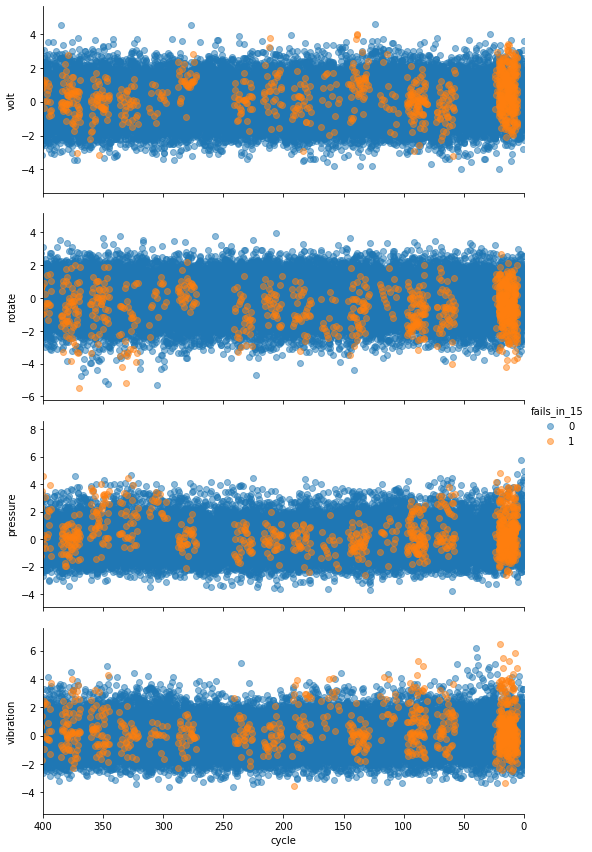

In [205]:
import seaborn as sns

explore = sns.PairGrid(
    data=train,
    x_vars="cycle",
    y_vars=["volt", "rotate", "pressure", "vibration"],
    hue="fails_in_15", size=3, aspect=2.5)

explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()

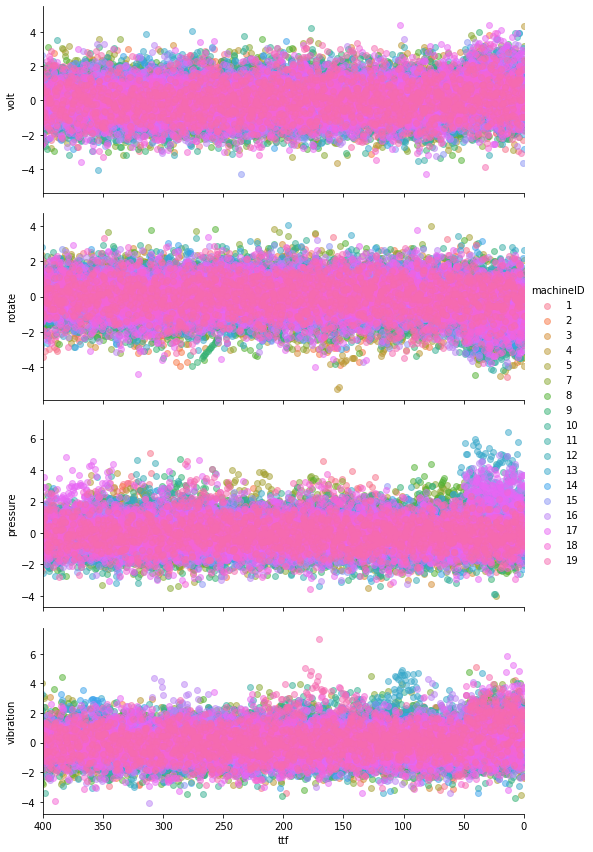

In [201]:
explore = sns.PairGrid(
    data=train[(train["machineID"] < 20) & (train["ttf"] != 9999)] ,
    x_vars="ttf",
    y_vars=["volt", "rotate", "pressure", "vibration"],
    hue="machineID", size=3, aspect=2.5)

explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()